In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    
def plot_loghist(x, bins, **kwargs):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, **kwargs)
    plt.xscale('log')
    
def plot_metrics_histogram(report, **hist_kwargs):
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(report.columns[1:], 1):
        plt.subplot(3, 2, idx)
        plot_loghist(report[metric], bins=50)
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
    plt.show()

34299


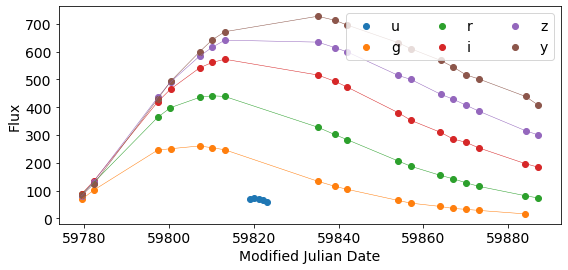

43812


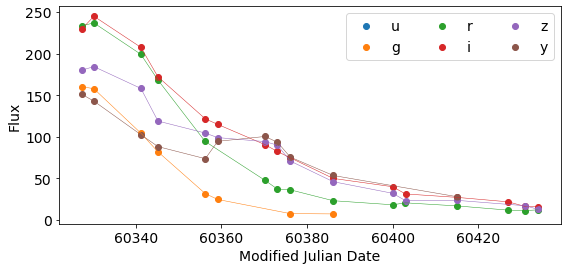

70046


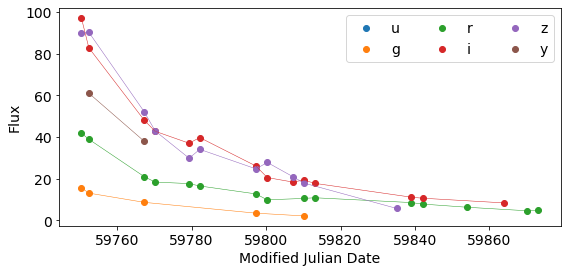

84716


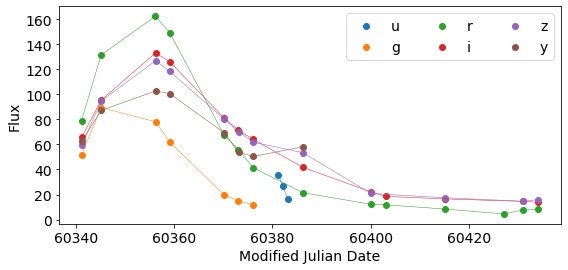

131629


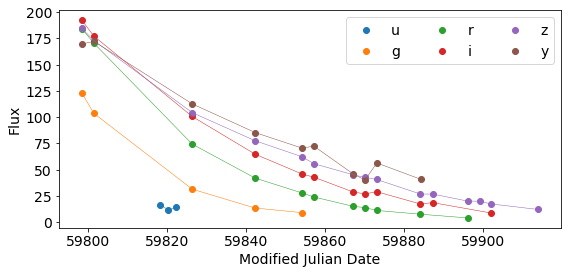

169315


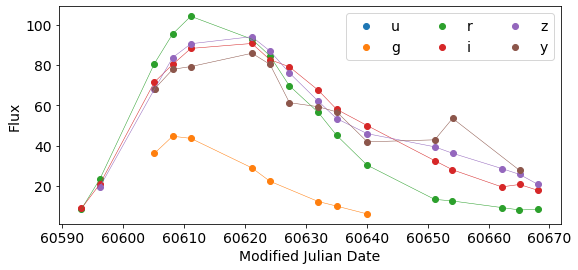

229855


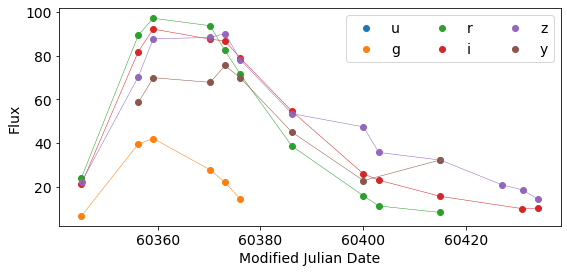

251430


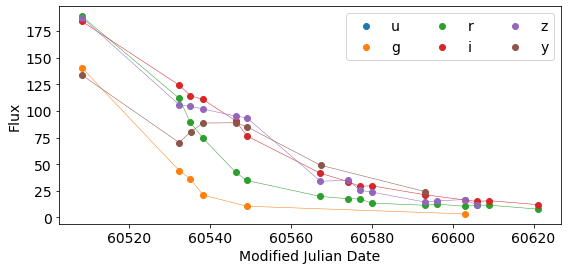

282714


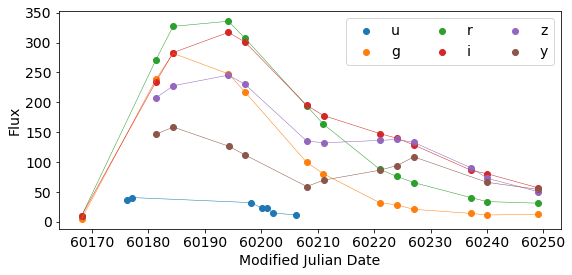

290682


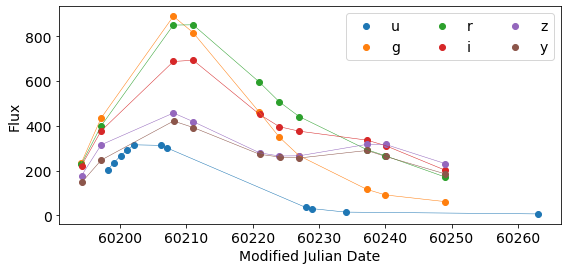

316306


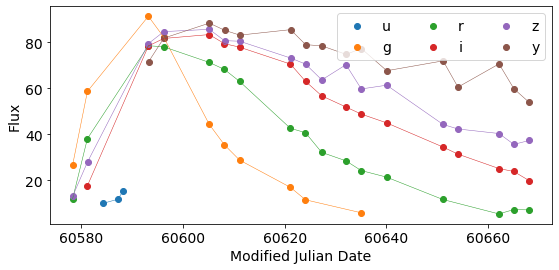

In [14]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

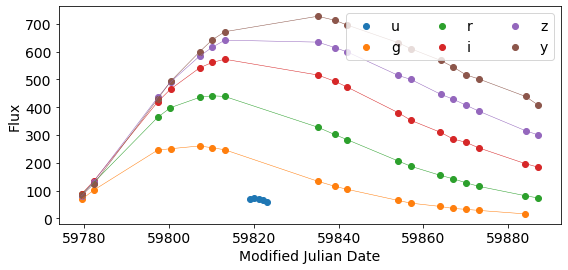

In [15]:
anobject = get_object(data, 34299)

plot_light_curves(anobject)

In [16]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [17]:
import rbfnet_aug

# fit augmentation model
model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=24, regularization='l2')
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [18]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

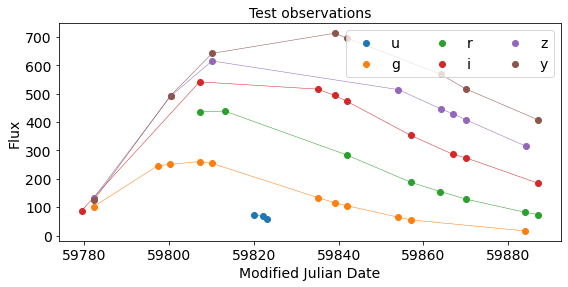

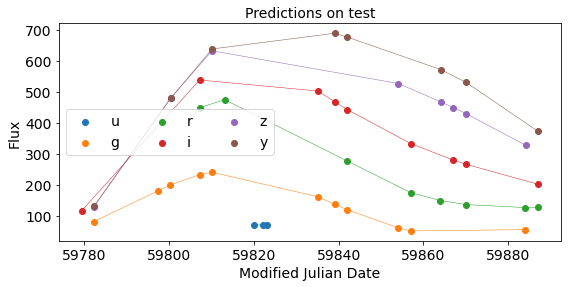

In [19]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

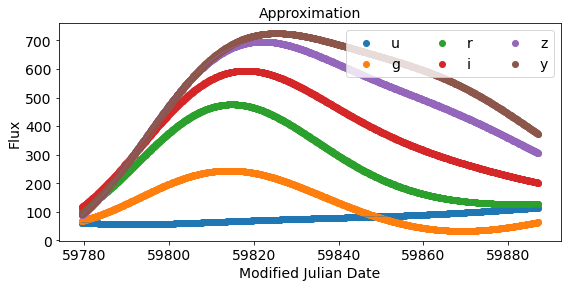

In [20]:
plot_light_curves(anobject_aug, "Approximation")

In [21]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  23.667615766181
MAE:  18.795899307950535
RSE:  0.11946113162041516
RAE:  0.10733530146515324
MAPE:  14.948056308974172


# Test on many objects

In [22]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids:
    
    # get an object
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    # fit augmentation model
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=24, regularization='l2')
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)
    
    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, flux_pred)
    report.loc[len(report), :] = [i] + list(metrics)

Object  745  with  61  observations
Object  1124  with  61  observations
Object  1920  with  55  observations
Object  2922  with  58  observations
Object  4173  with  77  observations
Object  4389  with  58  observations
Object  4819  with  73  observations
Object  6180  with  55  observations
Object  7033  with  72  observations
Object  7164  with  59  observations
Object  10321  with  106  observations
Object  10757  with  62  observations
Object  11359  with  80  observations
Object  11507  with  66  observations
Object  13079  with  71  observations
Object  13138  with  99  observations
Object  13194  with  61  observations
Object  13459  with  47  observations
Object  14279  with  74  observations
Object  14674  with  62  observations
Object  15002  with  58  observations
Object  15674  with  74  observations
Object  15845  with  75  observations
Object  15968  with  42  observations
Object  17370  with  90  observations
Object  18029  with  59  observations
Object  18556  with  9

Object  158042  with  54  observations
Object  158813  with  58  observations
Object  160048  with  92  observations
Object  160527  with  57  observations
Object  162093  with  56  observations
Object  162139  with  75  observations
Object  163208  with  61  observations
Object  163680  with  85  observations
Object  166186  with  48  observations
Object  166697  with  113  observations
Object  166727  with  49  observations
Object  167220  with  49  observations
Object  167310  with  55  observations
Object  167436  with  68  observations
Object  167910  with  52  observations
Object  168659  with  40  observations
Object  169203  with  51  observations
Object  169315  with  67  observations
Object  169678  with  76  observations
Object  170667  with  67  observations
Object  170753  with  83  observations
Object  171194  with  121  observations
Object  172231  with  52  observations
Object  173059  with  61  observations
Object  174258  with  67  observations
Object  174968  with  7

Object  285683  with  70  observations
Object  285912  with  37  observations
Object  286936  with  78  observations
Object  289325  with  64  observations
Object  290322  with  61  observations
Object  290559  with  81  observations
Object  290682  with  61  observations
Object  290877  with  61  observations
Object  291304  with  80  observations
Object  291834  with  61  observations
Object  292021  with  71  observations
Object  292533  with  99  observations
Object  292571  with  67  observations
Object  294237  with  102  observations
Object  294647  with  59  observations
Object  296390  with  79  observations
Object  298802  with  84  observations
Object  298918  with  73  observations
Object  299348  with  64  observations
Object  300864  with  62  observations
Object  301420  with  40  observations
Object  301956  with  49  observations
Object  302209  with  80  observations
Object  303024  with  57  observations
Object  303122  with  59  observations
Object  303200  with  81

In [23]:
np.round(report.mean(), 2)

ID      340898.23
RMSE        40.33
MAE         27.05
RSE          0.36
RAE          0.30
MAPE        37.95
dtype: float64

In [24]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,10.2764,7.60083,0.196314,0.205555,32.9146
1,1124,12.5589,8.08152,0.337762,0.301929,55.3099
2,1920,37.6534,26.1801,0.608744,0.523723,76.5479
3,2922,26.9289,18.7209,0.389166,0.531864,68.973
4,4173,10.3804,6.99697,0.209353,0.170504,14.0979
...,...,...,...,...,...,...
511,339169,4.37013,2.96301,0.293682,0.229338,11.1103
512,341653,16.8674,10.13,0.565609,0.400163,30.1885
513,342659,12.6056,10.2052,0.37097,0.366566,39.7037
514,8366012,55.9736,37.9938,0.458934,0.345022,91.8222


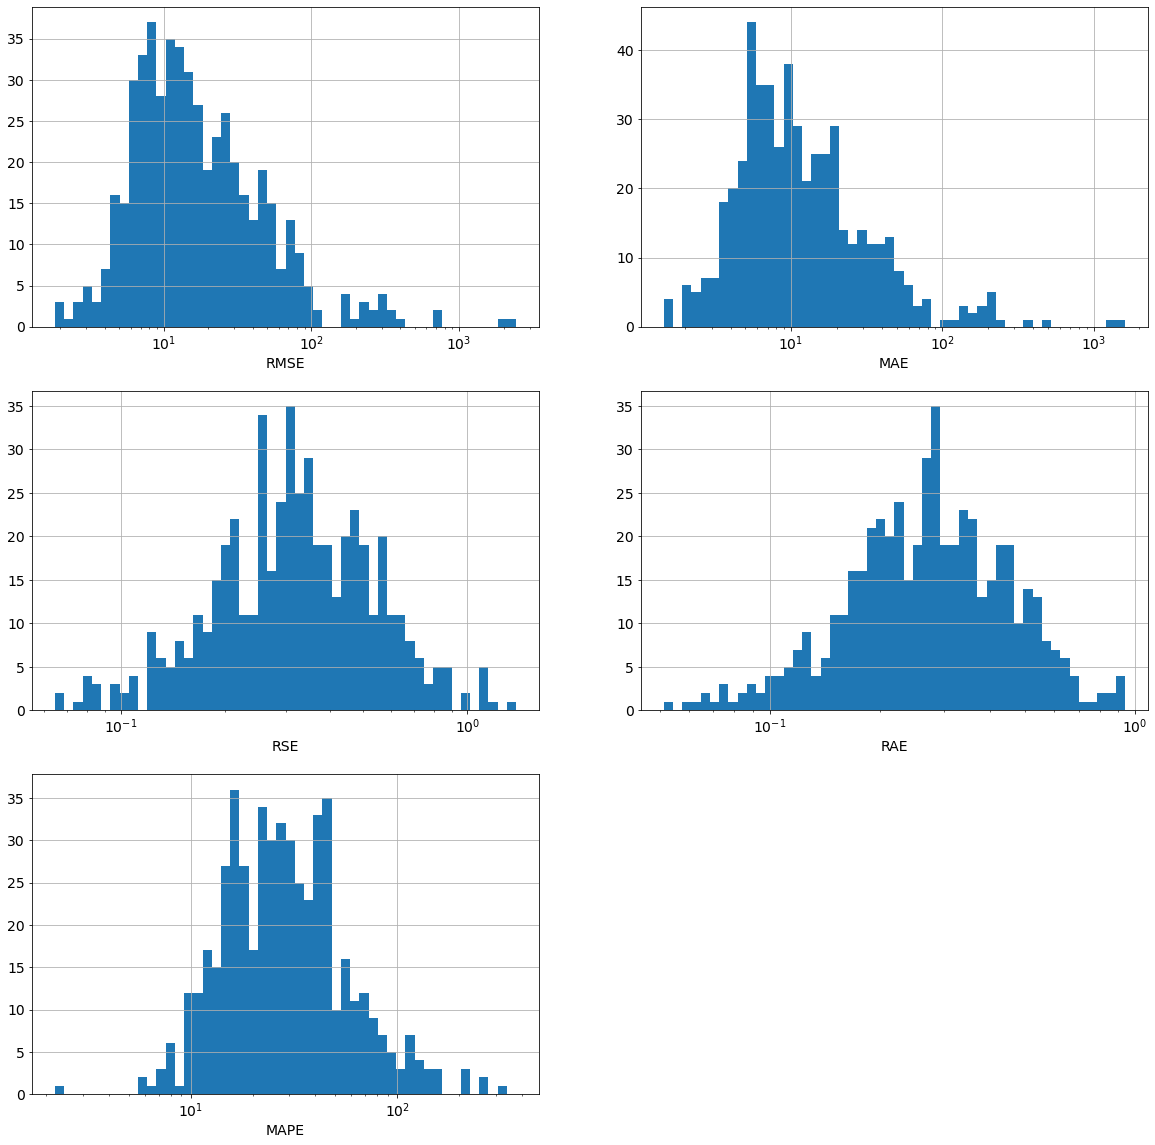

In [25]:
plot_metrics_histogram(report)

34299


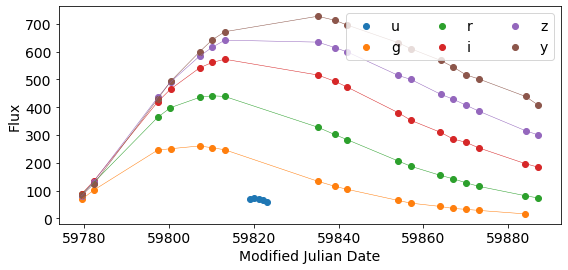

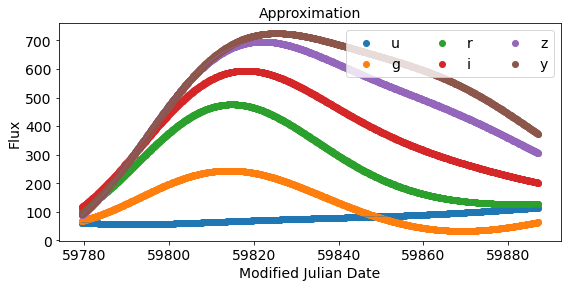

43812


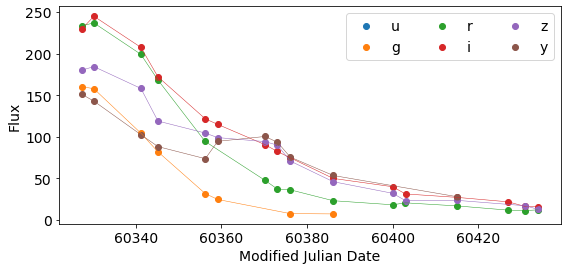

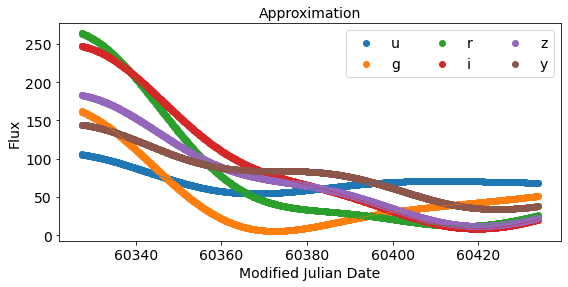

70046


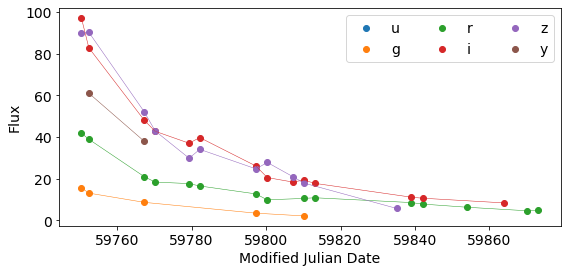

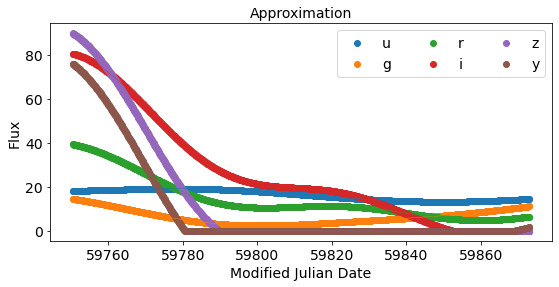

84716


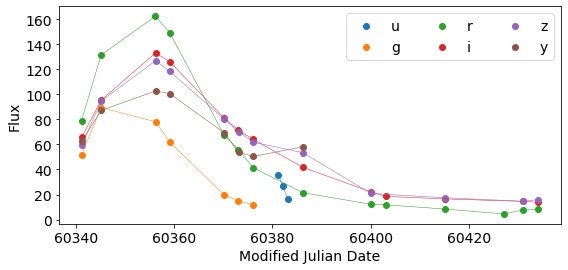

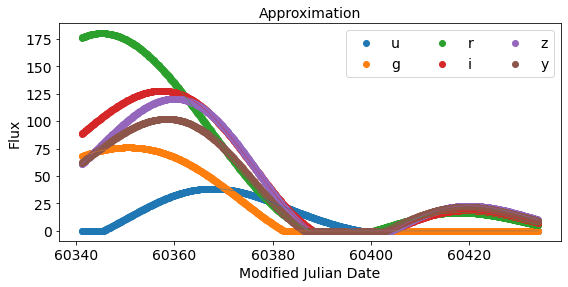

131629


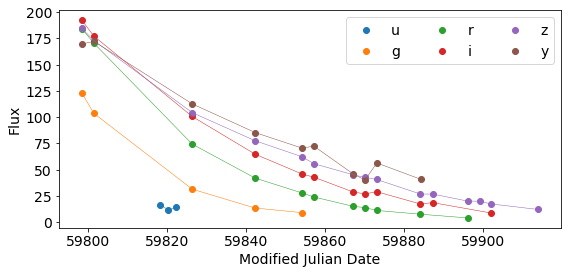

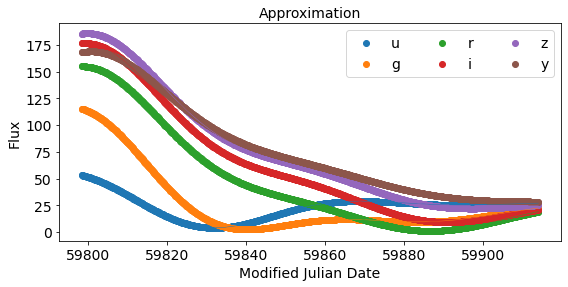

169315


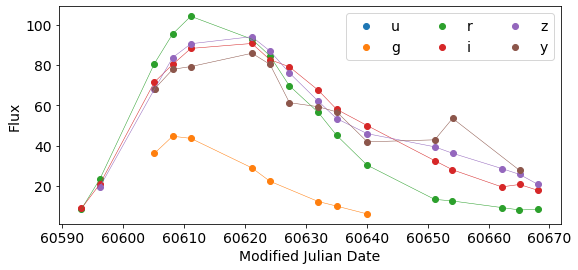

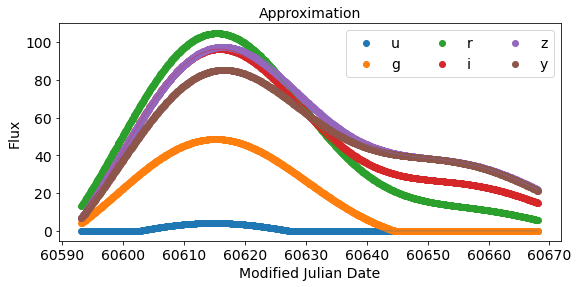

229855


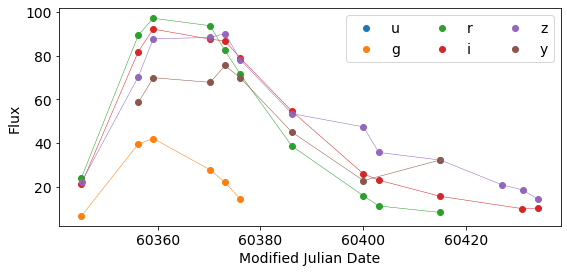

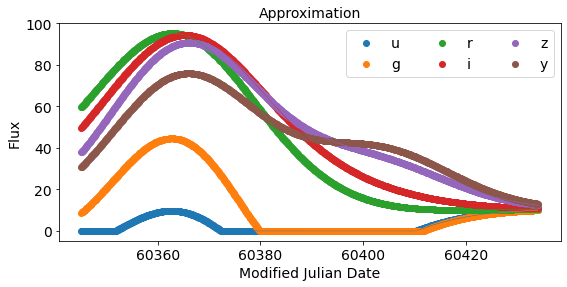

251430


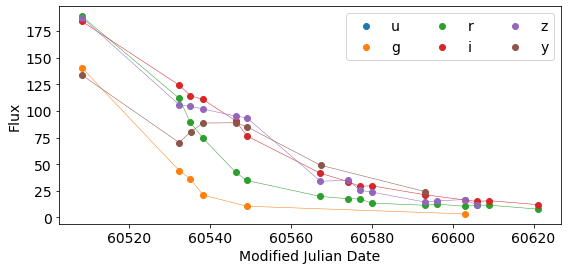

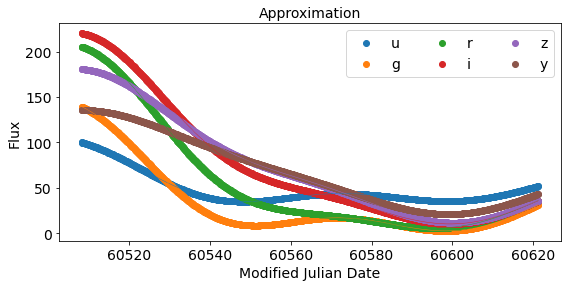

282714


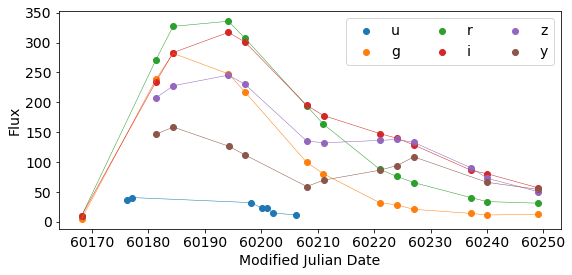

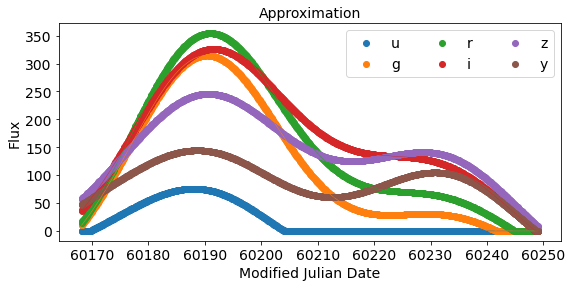

290682


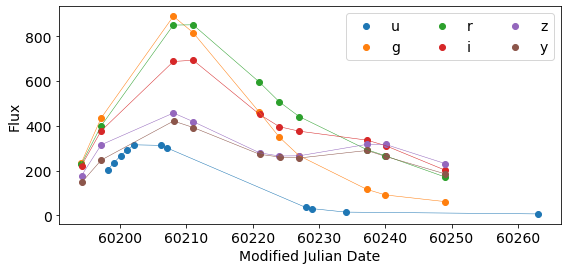

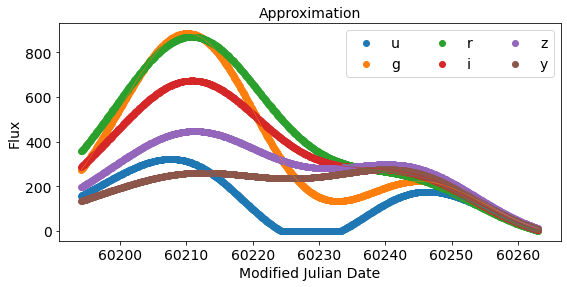

316306


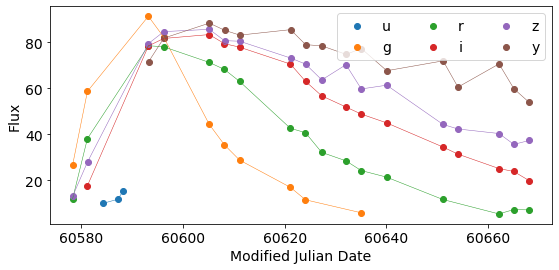

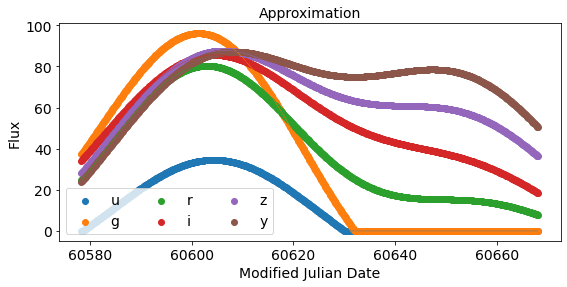

In [26]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()
    
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=24, regularization='l2')
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=1000)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    plot_light_curves(anobject_aug, "Approximation")
    plt.show()